In [36]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from google.colab import drive
import torchvision
from torch.utils.data import Dataset, DataLoader
import os

drive.mount('/content/drive')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cpu


In [37]:
def get_resnet18():
    model = models.resnet18(weights=None)
    model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    model.fc = nn.Linear(512, 10)
    return model.to(device)

def get_resnet50():
    model = models.resnet50(weights=None)
    model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    model.fc = nn.Linear(2048, 10)
    return model.to(device)

In [38]:
class RobustDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        lbl = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, lbl

In [39]:
datasets = ['adversarial_examples_resnet18', 'adversarial_examples_resnet50', 'pgd_robust_adversarial_examples_resnet18', 'pgd_robust_adversarial_examples_resnet50']


In [40]:
per_dataset_generated_attacks = []
per_dataset_true_labels = []
for dataset_name in datasets:
  robust_eval_dataset = torch.load(f"/content/drive/My Drive/adversarial_mnist/{dataset_name}/all_fooling_examples.pth")
  images = robust_eval_dataset["adversarial_examples"]
  true_labels = robust_eval_dataset["true_labels"]
  per_dataset_generated_attacks.append(images)
  per_dataset_true_labels.append(torch.tensor(true_labels))


In [41]:
# transform = transforms.Compose([transforms.ToTensor()])
# test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
# test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

# def pgd_attack(model, images, labels, eps=0.3, alpha=2/255, iters=10):
#     images = images.to(device)
#     labels = labels.to(device)
#     loss = nn.CrossEntropyLoss()

#     ori_images = images.data

#     for i in range(iters):
#         images.requires_grad = True
#         outputs = model(images)

#         model.zero_grad()
#         cost = loss(outputs, labels).to(device)
#         cost.backward()

#         adv_images = images + alpha * images.grad.sign()
#         eta = torch.clamp(adv_images - ori_images, min=-eps, max=eps)
#         images = torch.clamp(ori_images + eta, min=0, max=1).detach_()

#     return images

In [42]:
base_path = '/content/drive/My Drive/adversarial_mnist/saved_models/'

model_names = [
    'Standard ResNet18',
    'Standard ResNet50',
    'Robust ResNet18',
    'Robust ResNet50'
]

file_names = [
    'resnet18_standard_trained.pth',
    'resnet50_standard_trained.pth',
    'resnet18_pgd_robust.pth',
    'resnet50_pgd_robust.pth'
]

models_list = []

print("Loading models...")

m1 = get_resnet18()
m1.load_state_dict(torch.load(base_path + file_names[0], map_location=device))
m1.eval()
models_list.append(m1)

m2 = get_resnet50()
m2.load_state_dict(torch.load(base_path + file_names[1], map_location=device))
m2.eval()
models_list.append(m2)

m3 = get_resnet18()
m3.load_state_dict(torch.load(base_path + file_names[2], map_location=device))
m3.eval()
models_list.append(m3)

m4 = get_resnet50()
m4.load_state_dict(torch.load(base_path + file_names[3], map_location=device))
m4.eval()
models_list.append(m4)

print("All 4 models loaded successfully.")

Loading models...
All 4 models loaded successfully.


In [43]:
num_models = len(models_list)
accuracy_matrix = np.zeros((num_models, num_models))
num_batches = 5

print("Starting Transfer Attack Analysis...")

for i, source_model in enumerate(models_list):
    print(f"Generating attacks from Source: {model_names[i]}")

    source_attacks = per_dataset_generated_attacks[i]
    source_labels = per_dataset_true_labels[i]

    for j, target_model in enumerate(models_list):
        with torch.no_grad():
            outputs = target_model(source_attacks)
            _, preds = torch.max(outputs, 1)
            correct = (preds == source_labels).sum().item()
            acc = (correct / len(source_labels)) * 100
            accuracy_matrix[i, j] = acc

print("Analysis Complete.")

Starting Transfer Attack Analysis...
Generating attacks from Source: Standard ResNet18
Generating attacks from Source: Standard ResNet50
Generating attacks from Source: Robust ResNet18
Generating attacks from Source: Robust ResNet50
Analysis Complete.


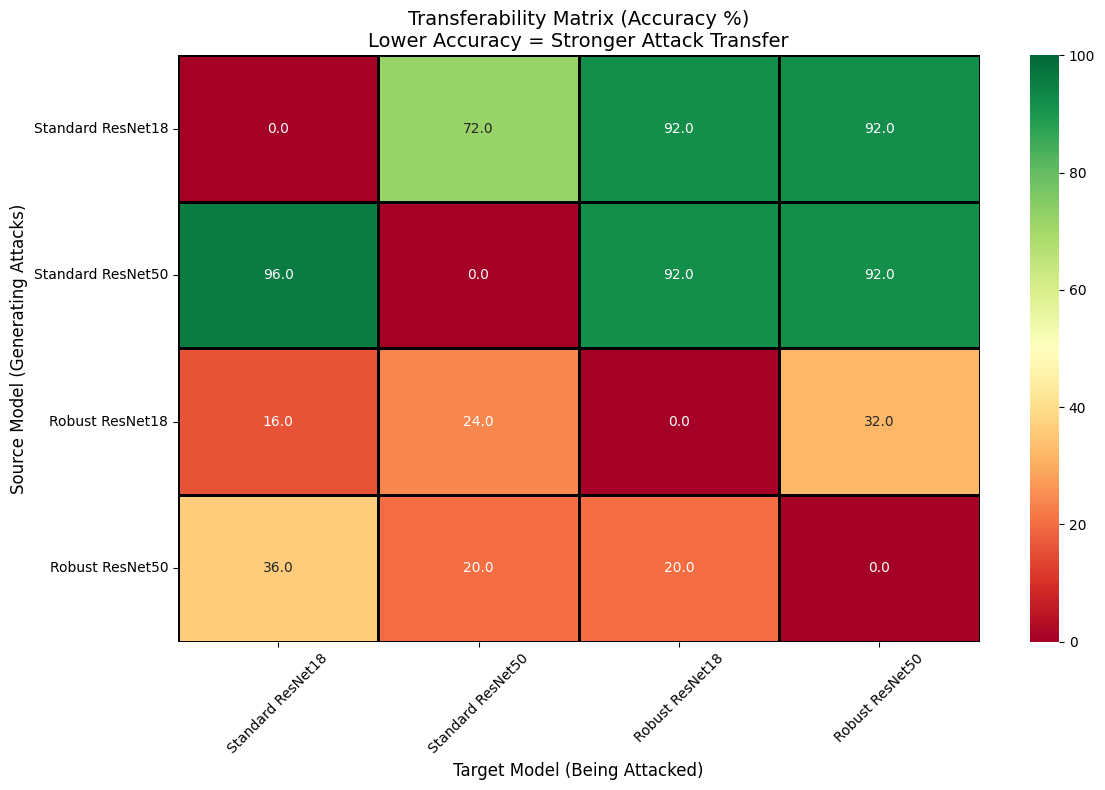

In [44]:
plt.figure(figsize=(12, 8))
sns.heatmap(accuracy_matrix, annot=True, fmt=".1f", cmap="RdYlGn",
            xticklabels=model_names, yticklabels=model_names,
            vmin=0, vmax=100, linewidths=1, linecolor='black')

plt.title('Transferability Matrix (Accuracy %)\nLower Accuracy = Stronger Attack Transfer', fontsize=14)
plt.xlabel('Target Model (Being Attacked)', fontsize=12)
plt.ylabel('Source Model (Generating Attacks)', fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

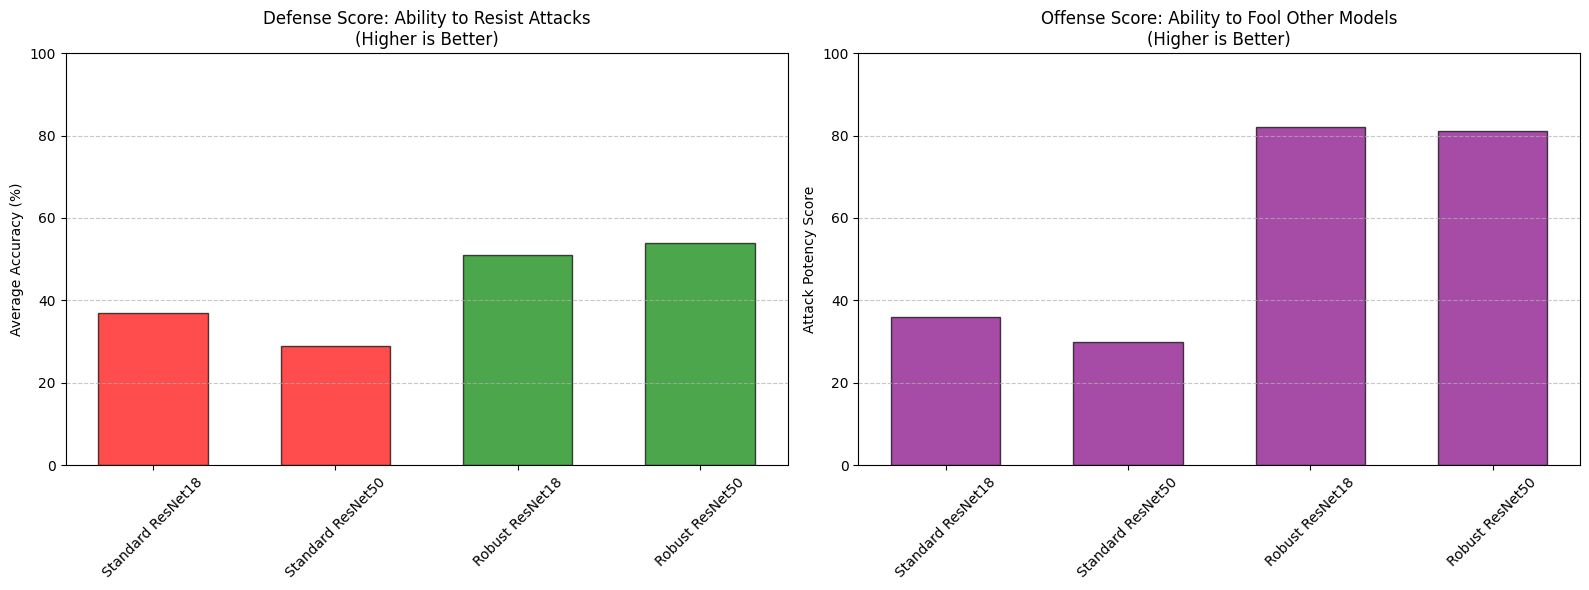

In [45]:
avg_robustness = np.mean(accuracy_matrix, axis=0)
avg_attack_strength = 100 - np.mean(accuracy_matrix, axis=1)

x = np.arange(len(model_names))
width = 0.6

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

colors_def = ['red' if 'Standard' in name else 'green' for name in model_names]
ax[0].bar(x, avg_robustness, width, color=colors_def, alpha=0.7, edgecolor='black')
ax[0].set_ylabel('Average Accuracy (%)')
ax[0].set_title('Defense Score: Ability to Resist Attacks\n(Higher is Better)')
ax[0].set_xticks(x)
ax[0].set_xticklabels(model_names, rotation=45)
ax[0].set_ylim(0, 100)
ax[0].grid(axis='y', linestyle='--', alpha=0.7)

ax[1].bar(x, avg_attack_strength, width, color='purple', alpha=0.7, edgecolor='black')
ax[1].set_ylabel('Attack Potency Score')
ax[1].set_title('Offense Score: Ability to Fool Other Models\n(Higher is Better)')
ax[1].set_xticks(x)
ax[1].set_xticklabels(model_names, rotation=45)
ax[1].set_ylim(0, 100)
ax[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [52]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

large_save_dir = '/content/drive/My Drive/adversarial_mnist/large_adversarial_examples'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

large_file_names = [
    '500_adv_resnet18_standard_trained.pth',
    '500_adv_resnet50_standard_trained.pth',
    '500_adv_resnet18_pgd_robust.pth',
    '500_adv_resnet50_pgd_robust.pth'
]

large_model_display_names = [
    'Standard ResNet18',
    'Standard ResNet50',
    'Robust ResNet18',
    'Robust ResNet50'
]

large_attacks = []
large_labels = []
perturbation_costs = []

print("Loading Large (500) Adversarial Sets...")

for name in large_file_names:
    path = f"{large_save_dir}/{name}"
    if os.path.exists(path):
        data = torch.load(path, weights_only=False)
        large_attacks.append(data['adversarial_examples'])
        large_labels.append(data['true_labels'])
        perturbation_costs.append(data['avg_perturbation_l2'])
        print(f"Loaded {name}: {len(data['adversarial_examples'])} examples")
    else:
        print(f"File not found: {path}")

Loading Large (500) Adversarial Sets...
Loaded 500_adv_resnet18_standard_trained.pth: 500 examples
Loaded 500_adv_resnet50_standard_trained.pth: 500 examples
Loaded 500_adv_resnet18_pgd_robust.pth: 500 examples
Loaded 500_adv_resnet50_pgd_robust.pth: 500 examples


Running Transfer Analysis on Large Sets...


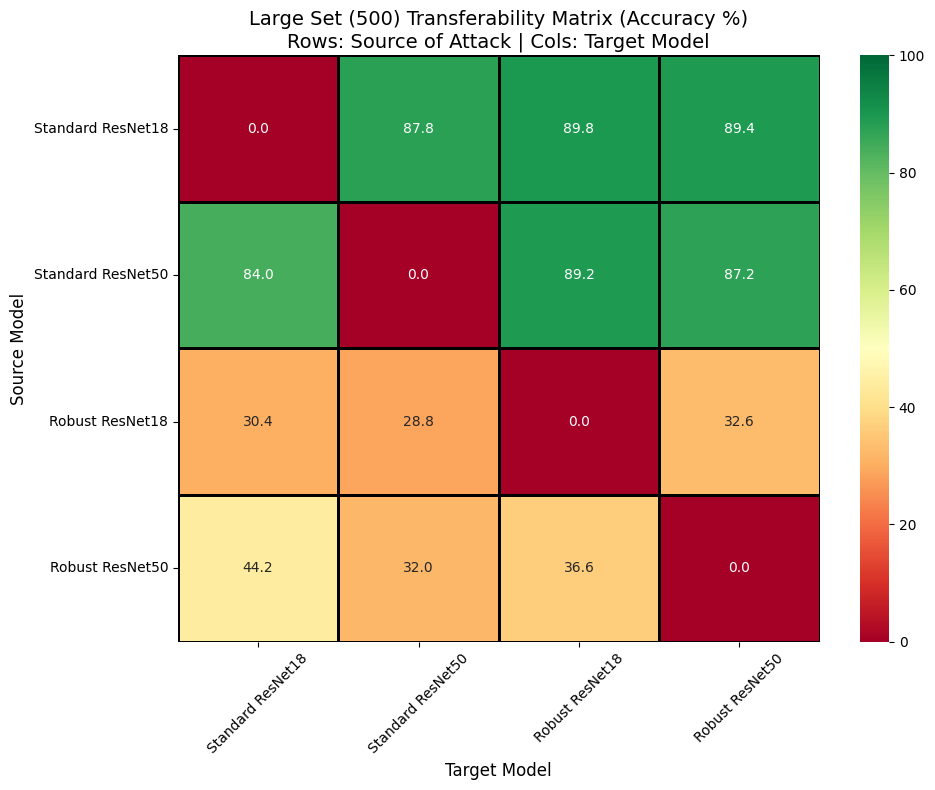

In [53]:
num_models = len(models_list)
large_accuracy_matrix = np.zeros((num_models, num_models))

print("Running Transfer Analysis on Large Sets...")

for i in range(num_models):
    if i < len(large_attacks):
        source_imgs = large_attacks[i].to(device)
        source_lbls = large_labels[i].to(device)

        for j, target_model in enumerate(models_list):
            target_model.eval()
            with torch.no_grad():
                outputs = target_model(source_imgs)
                _, preds = torch.max(outputs, 1)
                correct = (preds == source_lbls).sum().item()
                acc = (correct / len(source_lbls)) * 100
                large_accuracy_matrix[i, j] = acc

plt.figure(figsize=(10, 8))
sns.heatmap(large_accuracy_matrix, annot=True, fmt=".1f", cmap="RdYlGn",
            xticklabels=large_model_display_names, yticklabels=large_model_display_names,
            vmin=0, vmax=100, linewidths=1, linecolor='black')

plt.title('Large Set (500) Transferability Matrix (Accuracy %)\nRows: Source of Attack | Cols: Target Model', fontsize=14)
plt.xlabel('Target Model', fontsize=12)
plt.ylabel('Source Model', fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

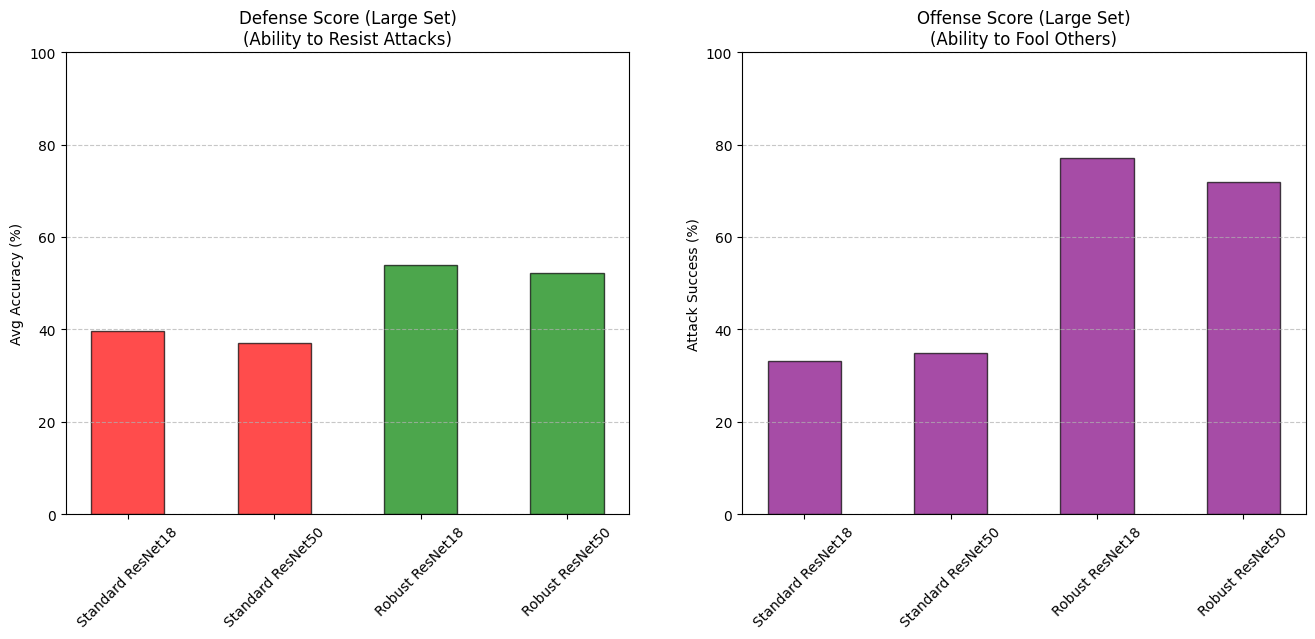

In [55]:
avg_robustness_large = np.mean(large_accuracy_matrix, axis=0)
avg_attack_strength_large = 100 - np.mean(large_accuracy_matrix, axis=1)

x = np.arange(len(large_model_display_names))
width = 0.5
colors_def = ['red' if 'Standard' in name else 'green' for name in large_model_display_names]

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

ax[0].bar(x, avg_robustness_large, width, color=colors_def, alpha=0.7, edgecolor='black')
ax[0].set_ylabel('Avg Accuracy (%)')
ax[0].set_title('Defense Score (Large Set)\n(Ability to Resist Attacks)')
ax[0].set_xticks(x)
ax[0].set_xticklabels(large_model_display_names, rotation=45)
ax[0].set_ylim(0, 100)
ax[0].grid(axis='y', linestyle='--', alpha=0.7)

ax[1].bar(x, avg_attack_strength_large, width, color='purple', alpha=0.7, edgecolor='black')
ax[1].set_ylabel('Attack Success (%)')
ax[1].set_title('Offense Score (Large Set)\n(Ability to Fool Others)')
ax[1].set_xticks(x)
ax[1].set_xticklabels(large_model_display_names, rotation=45)
ax[1].set_ylim(0, 100)
ax[1].grid(axis='y', linestyle='--', alpha=0.7)

<Figure size 640x480 with 0 Axes>

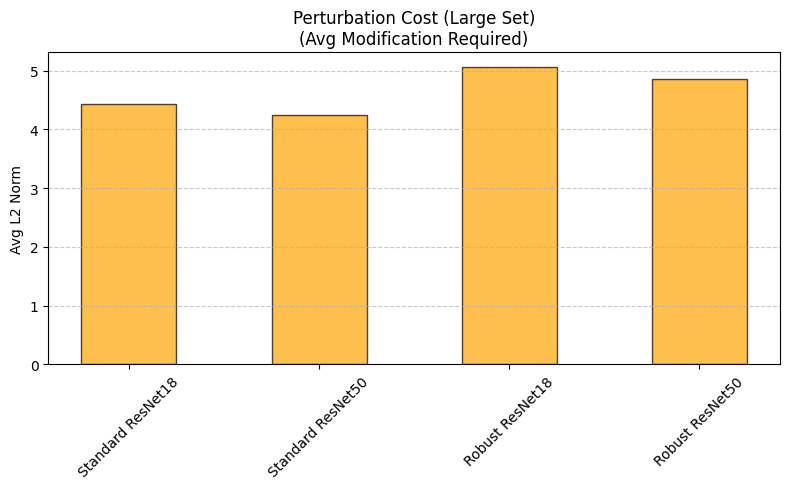

In [56]:
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
plt.bar(x, perturbation_costs, width, color='orange', alpha=0.7, edgecolor='black')
plt.ylabel('Avg L2 Norm')
plt.title('Perturbation Cost (Large Set)\n(Avg Modification Required)')
plt.xticks(x, large_model_display_names, rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()